In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    """
    The following function is used to read counts data generated by usearch into a dataframe
    Input: Usearch Data file
    Output: A pandas dataframe with the counts data
    """
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def findMutInString(query):
    """
    The following function is used to get the mutations for a particular qrowdots query in the coounts table
    Input: qrowdots
    Output: A dictionary with mutations and mutation position
    """
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}

def getMutationList(Mutations_Position):
    target = 'AGTTTTCCCTCGATGCGCCCATTGTCGCACATGAAAACTATCAATGGGCTAACTACGTTCGTGGCGTGGTGAAACATCTGCAACTGCGTAACAACAGCTT\
CGGCGGCGTGGACATGGTGATCAGCGGCAATGTGCCGCAGGGTGCCGGGTTAAGTTCTTCCGCTTCACTGGAAGTCGCGGTCGGAACCGTATTGCAGCAGCTTTATCATC\
TGCCGCTGGACGGCGCACAAATCGCGCTTAACGGTCAGGAAGCAGAAAACCAGTTTGTAGGCTGTAACTGCGGGATCATGGATCAGCTAATTTCCGCGCTCGGCAAGAAA\
GATCATGCCTTGCTGATCGATTGCCGCTCACTGGGGACCAAAGCAGTTTCCATGCCCAAAGGTGTGGCTGTCGTCATCATCAACA'
    target_list = list(target)
    mutation = ''
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                if position < 405:
                    mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(mutation_list):
    try:
        coding_seq = 'aacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtct'
        codon_master_list = textwrap.wrap(coding_seq,3)
        codon_changes = ''
        position_list = []
        for mutation in mutation_list.split(','):
            codon_pos = int((float(mutation[1:-1])-1)/3)
            if codon_pos not in position_list:
                position_list.append(codon_pos)
                codon = codon_master_list[int(codon_pos)]
                codon_list = list(codon)
                codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
            else:
                old_index = position_list.index(53)
                codon = codon_master_list[int(codon_pos)]
                codon_list = list(codon)
                codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                mutation = mutation_list.split(',')[old_index]
                codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                l = codon_changes.split(",")
                del l[old_index]
                codon_changes = ",".join(l)
        return codon_changes[:-1]
    except ValueError:
        pass

def aachange(codon_changes):
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+518)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'
    return aa_change[:-1]  

In [2]:
def getFilteredMutationDataFrame(filename,minCountFilter):
    df = convertUsearchToValueCounts(filename,'Counts')
    df_Filter = df.loc[df.Counts > minCountFilter]
    df_Filter = df_Filter.loc[~df_Filter.qrowdots.str[0:24].str.contains('A|T|C|G')]
    df_Filter = df_Filter.loc[~df_Filter.qrowdots.str[349:].str.contains('A|T|C|G')]
    df_Filter['Mutations_Position'] = df_Filter.qrowdots.apply(findMutInString)
    df_Filter['Mutations'] = df_Filter.Mutations_Position.apply(getMutationList)
    df_Filter['Num_Mutations'] = df_Filter.qrowdots.str.count('A|T|C|G')
    return df_Filter

#Get mutations and Counts data for pre library with low error rate
df_pre_low_A = getFilteredMutationDataFrame('169.fastq.assembled',0)
df_pre_low_B = getFilteredMutationDataFrame('171.fastq.assembled',0)

#Get mutations and Counts data for pre library with high error rate
df_pre_high_A = getFilteredMutationDataFrame('170.fastq.assembled',0)
df_pre_high_B = getFilteredMutationDataFrame('172.fastq.assembled',0)
print "pre Done"

#Get mutations and Counts data for high donor 
df_50_high_A = getFilteredMutationDataFrame('163.fastq.assembled',1)
df_50_high_B = getFilteredMutationDataFrame('164.fastq.assembled',1)

#Get mutations and Counts data for pre library with low error rate
df_150_high_A = getFilteredMutationDataFrame('165.fastq.assembled',1)
df_150_high_B = getFilteredMutationDataFrame('166.fastq.assembled',1)

#Get mutations and Counts data for pre library with low error rate
df_250_high_A = getFilteredMutationDataFrame('167.fastq.assembled',1)
df_250_high_B = getFilteredMutationDataFrame('168.fastq.assembled',1)
print "High Done"

#Get mutations and Counts data for low donor 
df_50_low_A = getFilteredMutationDataFrame('157.fastq.assembled',1)
df_50_low_B = getFilteredMutationDataFrame('158.fastq.assembled',1)

#Get mutations and Counts data for pre library with low error rate
df_150_low_A = getFilteredMutationDataFrame('159.fastq.assembled',1)
df_150_low_B = getFilteredMutationDataFrame('160.fastq.assembled',1)

#Get mutations and Counts data for pre library with low error rate
df_250_low_A = getFilteredMutationDataFrame('161.fastq.assembled',1)
df_250_low_B = getFilteredMutationDataFrame('162.fastq.assembled',1)
print "Low Done"

#Get mutations and counts for no mutL A and B
df_pCREPE_A = getFilteredMutationDataFrame('galK-pam-1_assembled',1)
df_pCREPE_B = getFilteredMutationDataFrame('galK-pam-2_assembled',1)

#Get mutations and counts for mutLE532K A and B
df_pCREPE_mutL_A = getFilteredMutationDataFrame('galK-mutL-3_assembled',1)
df_pCREPE_mutL_B = getFilteredMutationDataFrame('galK-mutL-4_assembled',1)
print "mutL Done"


pre Done
High Done
Low Done
mutL Done


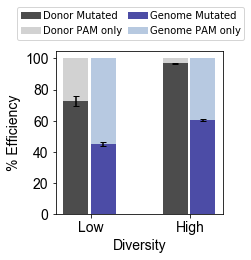

In [3]:
"""
Plot for impact of donor diversity on editing efficiency.
"""
fig = plt.figure(figsize=(3,3))
# set width of bar
barWidth = 0.25

#SetData
means_donor = np.array([72.85,96.84])
means_genomic = np.array([44.97,60.305])
err_donor = np.array([3.29,0.12])
err_genomic = np.array([1.24,0.635])

PAM_donor = 100 - means_donor
PAM_genomic = 100 - means_genomic

# Set position of bar on X axis
r1 = np.arange(len(means_donor))
r2 = [x + barWidth+0.03 for x in r1]

plt.bar(r1, means_donor, color='black', yerr = err_donor, capsize = 3, \
        width=barWidth, label='Donor Mutated',alpha = 0.7)
plt.bar(r1, PAM_donor, bottom=means_donor, color='silver', width=barWidth,\
        label='Donor PAM only', alpha = 0.7)

plt.bar(r2, means_genomic, color='navy', width=barWidth, yerr = err_genomic, capsize = 3,\
        label='Genome Mutated',alpha = 0.7)
plt.bar(r2, PAM_genomic, bottom=means_genomic, color='lightsteelblue', width=barWidth,\
        label='Genome PAM only',alpha = 0.9)
plt.yticks(fontname = 'Arial', fontsize = 14)
plt.xticks([r + barWidth/2 +0.025 for r in range(len(means_donor))], ['Low', 'High'],\
          fontname = 'Arial', fontsize = 14)
plt.ylabel('% Efficiency',fontname = 'Arial',fontsize = 14)
plt.xlabel('Diversity',fontname = 'Arial',fontsize = 14)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 2,loc = 'upper center',bbox_to_anchor = [0.45,1.3], fontsize = 10, handletextpad=0.2, columnspacing = 0.5)
plt.savefig('Percent Secondary Mutations Error.svg',format = 'svg', \
            dpi = 300, transparent = True, bbox_inches = 'tight')

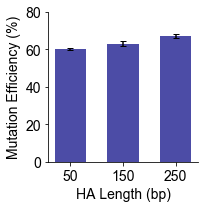

In [4]:
"""
Plot for impact of HA length on editing efficiency with high diversity donor library
"""
fig,ax = plt.subplots(figsize=(3,3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
n_groups = 2
barWidth = 0.6
means_mutation = np.array([60.305,63.0,67.2])
means_mutation2 = 100 - means_mutation
std_mutation = (0.63,1.23,1.1)
index = [1,2,3]
ax.bar(index, means_mutation, color='navy',width=barWidth, yerr=std_mutation, align='center', alpha = 0.7,\
        label = '_nolegend_', capsize = 3)
plt.ylabel('Mutation Efficiency (%)',fontname = 'Arial',fontsize = 14)
plt.xlabel('HA Length (bp)',fontname = 'Arial',fontsize = 14)
plt.xticks(index,('50','150','250' ),fontname = 'Arial',rotation=0,\
                fontsize = 14, ha = 'center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,80)
plt.yticks(fontname = 'Arial', fontsize = 14)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Percent Secondary Mutations HA Length.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches = 'tight')


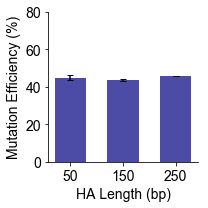

In [5]:
"""
Plot for impact of HA length on editing efficiency with Low diversity donor library
"""
fig,ax = plt.subplots(figsize=(3,3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
n_groups = 2
barWidth = 0.6
means_mutation = np.array([44.97,43.55,45.72])
means_mutation2 = 100 - means_mutation
std_mutation = (1.24,0.38,0.12)
index = [1,2,3]
plt.bar(index, means_mutation, color='navy',width=barWidth, yerr=std_mutation, align='center', alpha = 0.7,\
        label = '_nolegend_', capsize = 3)
plt.ylabel('Mutation Efficiency (%)',fontname = 'Arial',fontsize = 14)
plt.xlabel('HA Length (bp)',fontname = 'Arial',fontsize = 14)
plt.xticks(index,('50','150','250' ),fontname = 'Arial',rotation=0,\
                fontsize = 14, ha = 'center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,80)
plt.yticks(fontname = 'Arial', fontsize = 14)
#plt.legend(ncol = 2, loc = 'upper center',bbox_to_anchor = [0.5,1.25],  fontsize = 12,handletextpad=0.2, columnspacing = 0.5)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Percent Secondary Mutations HA Length low.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches = 'tight')


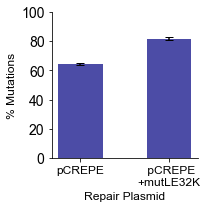

In [6]:
"""
Plot for impact of MutL-E532K on editing efficiency with high diversity donor library
"""
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(3,3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
n_groups = 2
barWidth = 0.5
means_mutation = np.array([64.43,81.8])
means_mutation2 = 100 - means_mutation
std_mutation = (0.79, 0.82)
index = [1,2]
plt.bar(index, means_mutation, color='navy', width = barWidth, yerr=std_mutation, align='center', alpha = 0.7,\
        label = 'Non-PAM', capsize = 4)
plt.ylabel('% Mutations',fontname = 'Arial',fontsize = 12)
plt.xlabel('Repair Plasmid',fontname = 'Arial',fontsize = 12)
plt.xticks(index,('pCREPE',' pCREPE\n+mutLE32K'),fontname = 'Arial',rotation=0,\
                fontsize = 12, ha = 'center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0,100)
plt.yticks(fontname = 'Arial', fontsize = 14)
#plt.legend(ncol = 2, loc = 'upper center',bbox_to_anchor = [0.5,1.25],  fontsize = 12,handletextpad=0.2, columnspacing = 0.5)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Percent Secondary Mutations mutL.svg',format = 'svg', dpi = 300,  transparent = True, bbox_inches = 'tight')


In [14]:
"""
Several reads with low counts are usually erroneous due to sequencing errors.

Therefore, we filter data for our analyses.

PS: No filtering does not change our conclusions
"""
df_pre_high_A = df_pre_high_A.loc[df_pre_high_A.Counts > 1]
df_pre_high_B = df_pre_high_B.loc[df_pre_high_B.Counts > 1]

df_50_high_A = df_50_high_A.loc[df_50_high_A.Counts > 5]
df_50_high_B = df_50_high_B.loc[df_50_high_B.Counts > 5]

df_250_high_A = df_250_high_A.loc[df_250_high_A.Counts > 5]
df_250_high_B = df_250_high_B.loc[df_250_high_B.Counts > 5]

df_50_low_A = df_50_low_A.loc[df_50_low_A.Counts > 5]
df_50_low_B = df_50_low_B.loc[df_50_low_B.Counts > 5]

df_250_low_A = df_250_low_A.loc[df_250_low_A.Counts > 5]
df_250_low_B = df_250_low_B.loc[df_250_low_B.Counts > 5]

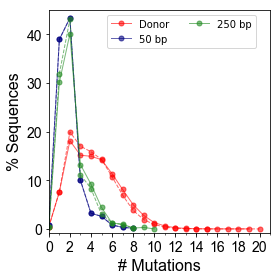

In [15]:
#Comparion between genome with high diveristy 50 and 250 bp HA inset
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)

plt.plot(df_pre_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_high_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'red',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)


plt.plot(df_50_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='50 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_50_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_high_A.Counts.sum()*100,\
         'o',linestyle = '--', color = 'navy',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_250_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'forestgreen',label ='250 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_250_high_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_high_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'forestgreen',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.ylim([-0.8,45])
plt.xlim([0,21])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 22, 2.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 2, loc = 'upper center', bbox_to_anchor = [0.6,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_HAHigh.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

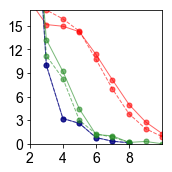

In [16]:
#Comparion between genome with high diveristy 50 and 250 bp HA inset
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(2.5,2.5))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
df_50_high_A = df_50_high_A.loc[df_50_high_A.Counts > 5]
df_50_high_B = df_50_high_B.loc[df_50_high_B.Counts > 5]

df_250_high_A = df_250_high_A.loc[df_250_high_A.Counts > 5]
df_250_high_B = df_250_high_B.loc[df_250_high_B.Counts > 5]

plt.plot(df_pre_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_high_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'red',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)


plt.plot(df_50_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='50 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_50_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_high_A.Counts.sum()*100,\
         'o',linestyle = '--', color = 'navy',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_250_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'forestgreen',label ='250 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_250_high_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_high_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'forestgreen',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.ylim([0,17])
plt.xlim([2,10])
plt.xticks(np.arange(2, 10, 2.0), fontname="Arial",fontsize = 14)
plt.yticks(np.arange(0, 18, 3.0),fontname="Arial",fontsize = 14)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_HAHigh_Inset.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

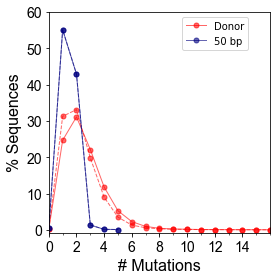

In [17]:
#Comparion between genome with low diveristy 50 and 250 bp HA
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
df_50_low_A = df_50_low_A.loc[df_50_low_A.Counts > 5]
df_50_low_B = df_50_low_B.loc[df_50_low_B.Counts > 5]

df_250_low_A = df_250_low_A.loc[df_250_low_A.Counts > 5]
df_250_low_B = df_250_low_B.loc[df_250_low_B.Counts > 5]


plt.plot(df_pre_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_low_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'red',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_50_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='50 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_50_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_low_A.Counts.sum()*100,\
         'o',linestyle = '--', color = 'navy',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.ylim([-0.8,60])
plt.xlim([0,16])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 16, 2.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_HAlow_donor_genome.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

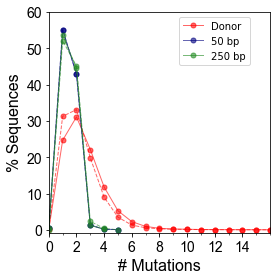

In [18]:
#Comparion between genome with low diveristy 50 and 250 bp HA
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
df_pre_low_A
plt.plot(df_pre_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_low_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'red',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_50_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='50 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_50_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_50_low_A.Counts.sum()*100,\
         'o',linestyle = '--', color = 'navy',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_250_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'forestgreen',label ='250 bp', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_250_low_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_250_low_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'forestgreen',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.ylim([-0.8,60])
plt.xlim([0,16])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 16, 2.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_HAlow.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

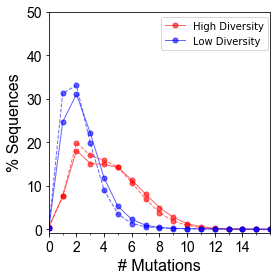

In [19]:
#Comparion between donors
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
df_pre_high_A
plt.plot(df_pre_high_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='High Diversity', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_high_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_high_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'red',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)

plt.plot(df_pre_low_A[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_A.Counts.sum()*100,\
         'o',linestyle = '-', color = 'blue',label ='Low Diversity', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_pre_low_B[['Counts','Num_Mutations']].groupby('Num_Mutations').sum()/df_pre_low_B.Counts.sum()*100,\
         'o',linestyle = '--', color = 'blue',label ='_nolegend_', alpha = 0.6, markersize = 5, linewidth = 1)


plt.ylim([-0.8,50])
plt.xlim([0,16])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 16, 2.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_donor_high_low.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [21]:
"""
The following code is to identify all single mutations in the populaiton
THen we calculate mutations based on the type of change
"""
df_pre_high_A_single = df_pre_high_A.loc[df_pre_high_A.Num_Mutations == 2]
df_pre_high_A_single = df_pre_high_A_single.assign(Mutations =\
                                                   df_pre_high_A_single.Mutations.str.replace('C187G',''))
df_pre_high_A_single = df_pre_high_A_single.assign(Mutations =\
                                                   df_pre_high_A_single.Mutations.str.replace(',',''))
df_pre_high_A_single = df_pre_high_A_single.assign(Change = \
                                                   df_pre_high_A_single.Mutations.str[0]+\
                                                  '>'+df_pre_high_A_single.Mutations.str[-1])
df_pre_high_A_single = df_pre_high_A_single.loc[(df_pre_high_A_single.Change != 'T>T')&\
(df_pre_high_A_single.Change != 'C>C') &\
(df_pre_high_A_single.Change != 'G>G')]

df_pre_high_B_single = df_pre_high_B.loc[df_pre_high_B.Num_Mutations == 2]
df_pre_high_B_single = df_pre_high_B_single.assign(Mutations =\
                                                   df_pre_high_B_single.Mutations.str.replace('C187G',''))
df_pre_high_B_single = df_pre_high_B_single.assign(Mutations =\
                                                   df_pre_high_B_single.Mutations.str.replace(',',''))
df_pre_high_B_single = df_pre_high_B_single.assign(Change = \
                                                   df_pre_high_B_single.Mutations.str[0]+\
                                                  '>'+df_pre_high_B_single.Mutations.str[-1])
df_pre_high_B_single = df_pre_high_B_single.loc[(df_pre_high_B_single.Change != 'T>T')&\
(df_pre_high_B_single.Change != 'C>C') &\
(df_pre_high_B_single.Change != 'G>G')]

df_pCREPE_A_single = df_pCREPE_A.loc[df_pCREPE_A.Num_Mutations == 2]
df_pCREPE_A_single = df_pCREPE_A_single.assign(Mutations =\
                                                   df_pCREPE_A_single.Mutations.str.replace('C187G',''))
df_pCREPE_A_single = df_pCREPE_A_single.assign(Mutations =\
                                                   df_pCREPE_A_single.Mutations.str.replace(',',''))
df_pCREPE_A_single = df_pCREPE_A_single.assign(Change = \
                                                   df_pCREPE_A_single.Mutations.str[0]+\
                                                  '>'+df_pCREPE_A_single.Mutations.str[-1])
df_pCREPE_A_single = df_pCREPE_A_single.loc[(df_pCREPE_A_single.Change != 'T>T')&\
(df_pCREPE_A_single.Change != 'C>C') &\
(df_pCREPE_A_single.Change != 'G>G')]

df_pCREPE_B_single = df_pCREPE_B.loc[df_pCREPE_B.Num_Mutations == 2]
df_pCREPE_B_single = df_pCREPE_B_single.assign(Mutations =\
                                                   df_pCREPE_B_single.Mutations.str.replace('C187G',''))
df_pCREPE_B_single = df_pCREPE_B_single.assign(Mutations =\
                                                   df_pCREPE_B_single.Mutations.str.replace(',',''))
df_pCREPE_B_single = df_pCREPE_B_single.assign(Change = \
                                                   df_pCREPE_B_single.Mutations.str[0]+\
                                                  '>'+df_pCREPE_B_single.Mutations.str[-1])
df_pCREPE_B_single = df_pCREPE_B_single.loc[(df_pCREPE_B_single.Change != 'T>T')&\
(df_pCREPE_B_single.Change != 'C>C') &\
(df_pCREPE_B_single.Change != 'G>G')]

df_pCREPE_mutL_A_single = df_pCREPE_mutL_A.loc[df_pCREPE_mutL_A.Num_Mutations == 2]
df_pCREPE_mutL_A_single = df_pCREPE_mutL_A_single.assign(Mutations =\
                                                   df_pCREPE_mutL_A_single.Mutations.str.replace('C187G',''))
df_pCREPE_mutL_A_single = df_pCREPE_mutL_A_single.assign(Mutations =\
                                                   df_pCREPE_mutL_A_single.Mutations.str.replace(',',''))
df_pCREPE_mutL_A_single = df_pCREPE_mutL_A_single.assign(Change = \
                                                   df_pCREPE_mutL_A_single.Mutations.str[0]+\
                                                  '>'+df_pCREPE_mutL_A_single.Mutations.str[-1])
df_pCREPE_mutL_A_single = df_pCREPE_mutL_A_single.loc[(df_pCREPE_mutL_A_single.Change != 'T>T')&\
(df_pCREPE_mutL_A_single.Change != 'C>C') &\
(df_pCREPE_mutL_A_single.Change != 'G>G')]

df_pCREPE_mutL_B_single = df_pCREPE_mutL_B.loc[df_pCREPE_mutL_B.Num_Mutations == 2]
df_pCREPE_mutL_B_single = df_pCREPE_mutL_B_single.assign(Mutations =\
                                                   df_pCREPE_mutL_B_single.Mutations.str.replace('C187G',''))
df_pCREPE_mutL_B_single = df_pCREPE_mutL_B_single.assign(Mutations =\
                                                   df_pCREPE_mutL_B_single.Mutations.str.replace(',',''))
df_pCREPE_mutL_B_single = df_pCREPE_mutL_B_single.assign(Change = \
                                                   df_pCREPE_mutL_B_single.Mutations.str[0]+\
                                                  '>'+df_pCREPE_mutL_B_single.Mutations.str[-1])
df_pCREPE_mutL_B_single = df_pCREPE_mutL_B_single.loc[(df_pCREPE_mutL_B_single.Change != 'T>T')&\
(df_pCREPE_mutL_B_single.Change != 'C>C') &\
(df_pCREPE_mutL_B_single.Change != 'G>G')]

In [24]:
#WE calculate the mutations based on the type of mutations
df_freqByMut = pd.DataFrame(100*df_pre_high_A_single.groupby('Change')\
                      .sum()['Counts']/df_pre_high_A_single.Counts.sum())
df_freqByMut.columns = ['preA']
df_freqByMut['preB'] = 100*df_pre_high_B_single.groupby('Change')\
                      .sum()['Counts']/df_pre_high_B_single.Counts.sum()

df_freqByMut['pCREPEA'] = 100*df_pCREPE_A_single.groupby('Change')\
                      .sum()['Counts']/df_pCREPE_A_single.Counts.sum()
df_freqByMut['pCREPEB'] = 100*df_pCREPE_B_single.groupby('Change')\
                      .sum()['Counts']/df_pCREPE_B_single.Counts.sum()

df_freqByMut['pCREPEMUTLA'] = 100*df_pCREPE_mutL_A_single.groupby('Change')\
                      .sum()['Counts']/df_pCREPE_mutL_A_single.Counts.sum()
df_freqByMut['pCREPEMUTLB'] = 100*df_pCREPE_mutL_B_single.groupby('Change')\
                      .sum()['Counts']/df_pCREPE_mutL_B_single.Counts.sum()


df_freqByMut['Donor'] = df_freqByMut[['preA','preB']].mean(axis = 1)
df_freqByMut['pCREPE'] = df_freqByMut[['pCREPEA','pCREPEB']].mean(axis = 1)
df_freqByMut['pCREPE+mutL E32K'] = df_freqByMut[['pCREPEMUTLA','pCREPEMUTLB']].mean(axis = 1)

df_freqByMut['Donor_EE'] = df_freqByMut[['preA','preB']].std(axis = 1)
df_freqByMut['pCREPE_EE'] = df_freqByMut[['pCREPEA','pCREPEB']].std(axis = 1)
df_freqByMut['pCREPE+mutL E32K_EE'] = df_freqByMut[['pCREPEMUTLA','pCREPEMUTLB']].std(axis = 1)

yerror = df_freqByMut[['Donor_EE','pCREPE_EE','pCREPE+mutL E32K_EE']]
yerror.columns = ['Donor','pCREPE','pCREPE+mutL E32K']

<Figure size 864x288 with 0 Axes>

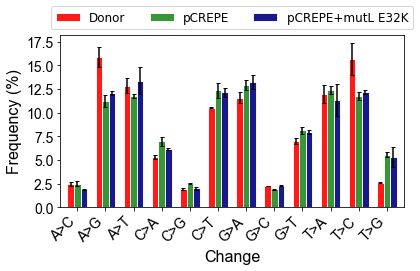

In [25]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(12,4))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)

df_freqByMut[['Donor','pCREPE','pCREPE+mutL E32K']].plot(kind='bar', color = ['red','forestgreen','navy'],\
                                                         yerr = yerror,alpha = 0.9,\
                                                         edgecolor ='white', width=0.7, capsize = 2)

plt.ylabel('Frequency (%)',  fontname="Arial",fontsize = 16)
plt.xlabel('Change',  fontname="Arial",fontsize = 16)
plt.xticks(fontname="Arial",fontsize = 14, rotation = 45, ha = 'right')
plt.yticks(fontname="Arial",fontsize = 14)

plt.style.use('seaborn-pastel')
plt.legend(ncol = 3, loc = 'upper center', bbox_to_anchor = [0.5,1.2], fontsize = 12)
plt.tight_layout()

plt.savefig('Frequency_Individuals_Mutations_mutL.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltsns
import time
import pandas as pd
import matplotlib.pyplot as plt

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch

def createMutationFrequencyTablefromUsearch(filename, seqLength):
    df_top = readUsearchOutputTodf(filename)
    df_trace = pd.DataFrame(index=['.','A','T','C','G','-'])
    for i in range(0,seqLength):
        df_trace_temp = df_top.qrowdots.str[i].value_counts('.').to_frame()
        df_trace_temp.columns = [i]
        df_trace = df_trace.join(df_trace_temp)
    df_mut = df_trace.transpose()
    df_mut = df_mut.fillna(0)
    df_mut['Mutation_Frequency'] = df_mut['A'] + df_mut['T'] + df_mut['C'] + df_mut['G']
    return df_mut

In [ ]:
df_pCREPE_mutL_A = createMutationFrequencyTablefromUsearch('Usearch/galK-mutL-3_assembled.fastq.txt',417)
df_pCREPE_mutL_B = createMutationFrequencyTablefromUsearch('Usearch/galK-mutL-4_assembled.fastq.txt',417)

df_pCREPE_A = createMutationFrequencyTablefromUsearch('Usearch/galK-pam-1_assembled.fastq.txt',417)
df_pCREPE_B = createMutationFrequencyTablefromUsearch('Usearch/galK-pam-2_assembled.fastq.txt',417)

df_pCREPE_mutL_250A = createMutationFrequencyTablefromUsearch('Usearch/13.fastq.txt',417)
df_pCREPE_mutL_250B = createMutationFrequencyTablefromUsearch('Usearch/14.fastq.txt',417)

df_pCREPE_mutL_50A = createMutationFrequencyTablefromUsearch('Usearch/15.fastq.txt',417)
df_pCREPE_mutL_50B = createMutationFrequencyTablefromUsearch('Usearch/16.fastq.txt',417)

df_pre_low_A = createMutationFrequencyTablefromUsearch('Usearch/169.fastq.assembled.fastq.txt',420)

df_50_low_A = createMutationFrequencyTablefromUsearch('Usearch/157.fastq.assembled.fastq.txt',420)
df_50_low_B = createMutationFrequencyTablefromUsearch('Usearch/158.fastq.assembled.fastq.txt',420)

df_150_low_A = createMutationFrequencyTablefromUsearch('Usearch/159.fastq.assembled.fastq.txt',420)
df_150_low_B = createMutationFrequencyTablefromUsearch('Usearch/160.fastq.assembled.fastq.txt',420)

df_250_low_A = createMutationFrequencyTablefromUsearch('Usearch/161.fastq.assembled.fastq.txt',420)
df_250_low_B = createMutationFrequencyTablefromUsearch('Usearch/162.fastq.assembled.fastq.txt',420)


df_pre_high_A = createMutationFrequencyTablefromUsearch('Usearch/170.fastq.assembled.fastq.txt',420)

df_50_high_A = createMutationFrequencyTablefromUsearch('Usearch/163.fastq.assembled.fastq.txt',420)
df_50_high_B = createMutationFrequencyTablefromUsearch('Usearch/164.fastq.assembled.fastq.txt',420)

df_150_high_A = createMutationFrequencyTablefromUsearch('Usearch/165.fastq.assembled.fastq.txt',420)
df_150_high_B = createMutationFrequencyTablefromUsearch('Usearch/166.fastq.assembled.fastq.txt',420)

df_250_high_A = createMutationFrequencyTablefromUsearch('Usearch/167.fastq.assembled.fastq.txt',420)
df_250_high_B = createMutationFrequencyTablefromUsearch('Usearch/168.fastq.assembled.fastq.txt',420)

In [27]:
df_pCREPE_A = pd.read_csv('Mutation_Freq/galK_no_mutL_A.csv',index_col=0)
df_pCREPE_B = pd.read_csv('Mutation_Freq/galK_no_mutL_B.csv',index_col=0)
df_pCREPE_mutL_A = pd.read_csv('Mutation_Freq/galK_mutL_A.csv',index_col=0)
df_pCREPE_mutL_B = pd.read_csv('Mutation_Freq/galK_mutL_B.csv',index_col=0)

df_pCREPE_A = df_pCREPE_A[0:400]
df_pCREPE_B = df_pCREPE_B[0:400]
df_pCREPE_mutL_A = df_pCREPE_mutL_A[0:400]
df_pCREPE_mutL_B = df_pCREPE_mutL_B[0:400]

df_pCREPE_A = df_pCREPE_A.drop([187])
df_pCREPE_B = df_pCREPE_B.drop([187])
df_pCREPE_mutL_A = df_pCREPE_mutL_A.drop([187])
df_pCREPE_mutL_B = df_pCREPE_mutL_B.drop([187])

In [38]:
df_pre_low_A = pd.read_csv('Mutation_Freq/169.csv',index_col=0)
df_50_low_A = pd.read_csv('Mutation_Freq/157.csv',index_col=0)
df_50_low_B = pd.read_csv('Mutation_Freq/158.csv',index_col=0)

df_150_low_A = pd.read_csv('Mutation_Freq/159.csv',index_col=0)
df_150_low_B = pd.read_csv('Mutation_Freq/160.csv',index_col=0)

df_250_low_A = pd.read_csv('Mutation_Freq/161.csv',index_col=0)
df_250_low_B = pd.read_csv('Mutation_Freq/162.csv',index_col=0)

df_pre_low_A = df_pre_low_A[0:400]
df_50_low_A = df_50_low_A[0:400]
df_50_low_B = df_50_low_B[0:400]

df_150_low_A = df_150_low_A[0:400]
df_150_low_B = df_150_low_B[0:400]

df_250_low_A = df_250_low_A[0:400]
df_250_low_B = df_250_low_B[0:400]


df_pre_low_A = df_pre_low_A.drop([187])
df_50_low_A = df_50_low_A.drop([187])
df_50_low_B = df_50_low_B.drop([187])

df_150_low_A = df_150_low_A.drop([187])
df_150_low_B = df_150_low_B.drop([187])

df_250_low_A = df_250_low_A.drop([187])
df_250_low_B = df_250_low_B.drop([187])

In [39]:
df_pre_high_A = pd.read_csv('Mutation_Freq/170.csv',index_col=0)

df_50_high_A = pd.read_csv('Mutation_Freq/163.csv',index_col=0)
df_50_high_B = pd.read_csv('Mutation_Freq/164.csv',index_col=0)

df_150_high_A = pd.read_csv('Mutation_Freq/165.csv',index_col=0)
df_150_high_B = pd.read_csv('Mutation_Freq/166.csv',index_col=0)

df_250_high_A = pd.read_csv('Mutation_Freq/167.csv',index_col=0)
df_250_high_B = pd.read_csv('Mutation_Freq/168.csv',index_col=0)

df_pre_high_A = df_pre_high_A[0:400]

df_50_high_A = df_50_high_A[0:400]
df_50_high_B = df_50_high_B[0:400]

df_150_high_A = df_150_high_A[0:400]
df_150_high_B = df_150_high_B[0:400]

df_250_high_A = df_250_high_A[0:400]
df_250_high_B = df_250_high_B[0:400]

df_pre_high_A = df_pre_high_A.drop([187])

df_50_high_A = df_50_high_A.drop([187])
df_50_high_B = df_50_high_B.drop([187])

df_150_high_A = df_150_high_A.drop([187])
df_150_high_B = df_150_high_B.drop([187])

df_250_high_A = df_250_high_A.drop([187])
df_250_high_B = df_250_high_B.drop([187])

In [40]:
df_50_high_A = df_50_high_A.assign(PAMDistance = abs(187 - df_50_high_A.index.values))

df_250_high_A = df_250_high_A.assign(PAMDistance = abs(187 - df_250_high_A.index.values))

df_pre_high_A = df_pre_high_A.assign(PAMDistance = abs(187 - df_pre_high_A.index.values))

df_pCREPE_A = df_pCREPE_A.assign(PAMDistance = abs(187 - df_pCREPE_A.index.values))

df_pCREPE_mutL_A = df_pCREPE_mutL_A.assign(PAMDistance = abs(187 - df_pCREPE_mutL_A.index.values))

df_50_high_B = df_50_high_B.assign(PAMDistance = abs(187 - df_50_high_B.index.values))

df_250_high_B = df_250_high_B.assign(PAMDistance = abs(187 - df_250_high_B.index.values))

df_pCREPE_B = df_pCREPE_B.assign(PAMDistance = abs(187 - df_pCREPE_B.index.values))

df_pCREPE_mutL_B = df_pCREPE_mutL_B.assign(PAMDistance = abs(187 - df_pCREPE_mutL_B.index.values))

df_50_low_A = df_50_low_A.assign(PAMDistance = abs(187 - df_50_low_A.index.values))

df_250_low_A = df_250_low_A.assign(PAMDistance = abs(187 - df_250_low_A.index.values))

df_pre_low_A = df_pre_low_A.assign(PAMDistance = abs(187 - df_pre_low_A.index.values))

df_50_low_B = df_50_low_B.assign(PAMDistance = abs(187 - df_50_low_B.index.values))

df_250_low_B = df_250_low_B.assign(PAMDistance = abs(187 - df_250_low_B.index.values))

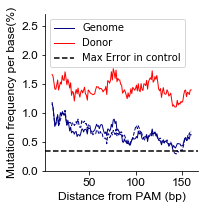

In [41]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
max_error = df_50_high_A[0:19].Mutation_Frequency.max()
df_50 = df_50_high_A[27:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_50 = df_50.dropna()
df_50_B = df_50_high_B[27:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_50_B = df_50_B.dropna()
df_50_pre = df_pre_high_A[27:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_50_pre = df_50_pre.dropna()
ax.plot(df_50.index.values, df_50.Mutation_Frequency*100, label = 'Genome', linewidth = 1,\
        color = 'navy',alpha = 1)
ax.plot(df_50_B.index.values, df_50_B.Mutation_Frequency*100, label = '_nolegend_', linestyle = '--', linewidth = 1,\
        color = 'navy',alpha = 1)
ax.plot(df_50_pre.index.values, df_50_pre.Mutation_Frequency*100, label = 'Donor', linestyle = '-', linewidth = 1,\
        color = 'red',alpha = 1)
ax.axhline(y=max_error*100, linestyle = '--' ,color = 'black', label = 'Max Error in control')

size = 12
plt.ylim([0,2.7])
plt.ylabel('Mutation frequency per base(%)',fontname = 'Arial', fontsize = size)
plt.xlabel('Distance from PAM (bp)',fontname = 'Arial',fontsize = size)
plt.yticks(fontname = 'Arial',fontsize = size)
plt.xticks(fontname = 'Arial',fontsize = size)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper left', fontsize = size-2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Mut_Rolling_Donor_Genome_high_error.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

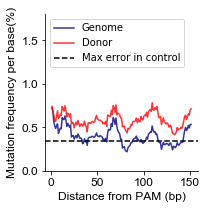

In [42]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
max_error = df_50_high_A[0:19].Mutation_Frequency.max()
df_50 = df_50_low_A[27:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').rolling(10).mean()
df_50 = df_50.dropna()
df_pre = df_pre_low_A[27:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').rolling(10).mean()
df_pre = df_pre.dropna()
ax.plot(df_50.index.values, df_50.Mutation_Frequency*100, label = 'Genome', color = 'navy',alpha = 0.8)
ax.plot(df_pre.index.values, df_pre.Mutation_Frequency*100, label = 'Donor', color = 'red',alpha = 0.8)
ax.axhline(y=max_error*100, linestyle = '--' ,color = 'black', label = 'Max error in control')
size = 12
plt.ylim([0,1.8])
plt.ylabel('Mutation frequency per base(%)',fontname = 'Arial', fontsize = size)
plt.xlabel('Distance from PAM (bp)',fontname = 'Arial',fontsize = size)
plt.yticks(fontname = 'Arial',fontsize = size)
plt.xticks(fontname = 'Arial',fontsize = size)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper left', fontsize = size-2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('Mut_Rolling_Donor_Genome_low_error.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [47]:
df_50 = df_50_high_A[28:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_50 = df_50.dropna()
df_250 = df_250_high_A[28:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_250 = df_250.dropna()
df_pre_high = df_pre_high_A[28:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_pre_high = df_pre_high.dropna()
df_pre_high = df_pre_high_A[28:187][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_pre_high = df_pre_high.dropna()

('coefficient of determination:', 0.6297444527239782)
('intercept:', -0.10499520927069123)
('slope:', array([-0.00423896]))
('coefficient of determination:', 0.3937520421317835)
('intercept:', 0.025024192046529087)
('slope:', array([-0.00306847]))
('coefficient of determination:', 0.12960653667427235)
('intercept:', 0.40971372315794397)
('slope:', array([-0.00081654]))


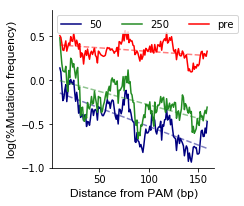

In [48]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)

import numpy as np
from sklearn.linear_model import LinearRegression
x = df_50.index.values.reshape((-1,1))
y = np.log(df_50.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred, color = 'navy' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'navy', label = '50')

x = df_250.index.values.reshape((-1,1))
y = np.log(df_250.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred,color = 'forestgreen' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'forestgreen', label = '250' )

x = df_pre_high.index.values.reshape((-1,1))
y = np.log(df_pre_high.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred,color = 'red' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'red', label = 'pre' )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([-1,0.8])
plt.ylabel('log(%Mutation frequency)',fontname = 'Arial', fontsize = size)
plt.xlabel('Distance from PAM (bp)',fontname = 'Arial',fontsize = size)

plt.legend(ncol = 3, loc = 'upper left', fontsize = size-2)

plt.savefig('Mut_Rolling_Donor_Genome_HA_2.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

('coefficient of determination:', 0.8720573693560757)
('intercept:', -0.6055218031744071)
('slope:', array([-0.00526427]))
('coefficient of determination:', 0.6955350050942717)
('intercept:', -0.315408643114627)
('slope:', array([-0.00271024]))
('coefficient of determination:', 0.11074546066392565)
('intercept:', 0.4029672118860785)
('slope:', array([-0.00074903]))


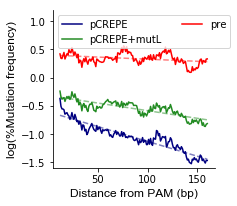

In [49]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)

df_pCrepe = df_pCREPE_A[27:185][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_pCrepe = df_pCrepe.dropna()

df_mutL = df_pCREPE_mutL_A[27:185][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_mutL = df_mutL.dropna()

df_pre_high = df_pre_high_A[27:185][['Mutation_Frequency','PAMDistance']].set_index('PAMDistance').sort_index().rolling(10).mean()
df_pre_high = df_pre_high.dropna()

import numpy as np
from sklearn.linear_model import LinearRegression
x = df_pCrepe.index.values.reshape((-1,1))
y = np.log(df_pCrepe.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred, color = 'navy' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'navy', label = 'pCREPE')

x = df_mutL.index.values.reshape((-1,1))
y = np.log(df_mutL.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred,color = 'forestgreen' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'forestgreen', label = 'pCREPE+mutL' )


x = df_pre_high.index.values.reshape((-1,1))
y = np.log(df_pre_high.Mutation_Frequency.values*100)
model = LinearRegression()
model.fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

y_pred = model.predict(x)
ax.plot(x,y_pred,color = 'red' , linestyle = '--', alpha = 0.5)
ax.plot(x,y, color = 'red', label = 'pre' )


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([-1.6,1.2])
plt.ylabel('log(%Mutation frequency)',fontname = 'Arial', fontsize = size)
plt.xlabel('Distance from PAM (bp)',fontname = 'Arial',fontsize = size)

plt.legend(ncol = 2, loc = 'upper left', fontsize = size-2)

plt.savefig('Mut_Rolling_Donor_Genome_mutL.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')